In [1]:
from io import open
import glob
import os

In [2]:
data_path = "C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data"

In [3]:
def findFiles(path): return glob.glob(path)

print(findFiles(f"{data_path}/names/*.txt"))

['C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Arabic.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Chinese.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Czech.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Dutch.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\English.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\French.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\German.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Greek.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Irish.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Italian.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Japanese.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Korean.txt', 'C:/Users/kyse1/Desktop/NLPFromScratchWithPytorch/data/names\\Polish.txt', 'C:/Users/kyse1/Desktop

In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Szczęsny'),unicodeToAscii('Ambrož'))

Szczesny Ambroz


In [6]:
# See the categories
for filename in findFiles(f'{data_path}/names/*.txt'):
    print(os.path.splitext(os.path.basename(filename))[0])

Arabic
Chinese
Czech
Dutch
English
French
German
Greek
Irish
Italian
Japanese
Korean
Polish
Portuguese
Russian
Scottish
Spanish
Vietnamese


In [7]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(f'{data_path}/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
    

In [8]:
for language in category_lines:
    print(category_lines[language][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']
['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']
['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven']
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']
['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']
['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']
['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']
['Adam', 'Ahearn', 'Aodh', 'Aodha', 'Aonghuis']
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']
['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']
['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']
['Abreu', 'Albuquerque', 'Almeida', 'Alves', 'Araujo']
['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin']
['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart']
['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']
['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']


### Turning Names into Tensors

In [9]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [10]:
import torch

# Find letter index from all_letters
def letterToIndex(letter): return all_letters.find(letter)

# Turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> 
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('B'))

print(lineToTensor('Erencan').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([7, 1, 57])


### Creating the Network
A Vanilla RNN

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input)) + self.h2h(hidden) # tanh ensures the hidden values stay between -1,1 for stability
        output = self.h2o(hidden)
        output = self.softmax(output) # produces log-probabilities
        return output, hidden
    
    # That function is called at the start of each sequence
    # It initalizes the hidden state to zeros before processing a new sequence
    # That ensures that each sequence starts with a fresh, neutral state.
    def initHidden(self):
        return torch.zeros(1, self.hidden_size) 
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.9027, -3.0186, -2.9324, -2.9069, -2.8394, -2.9938, -2.9259, -2.7764,
         -2.9401, -2.8887, -2.9092, -2.8803, -2.9147, -2.8155, -3.0258, -2.7677,
         -2.7794, -2.8601]], grad_fn=<LogSoftmaxBackward0>)

In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.9027, -3.0186, -2.9324, -2.9069, -2.8394, -2.9938, -2.9259, -2.7764,
         -2.9401, -2.8887, -2.9092, -2.8803, -2.9147, -2.8155, -3.0258, -2.7677,
         -2.7794, -2.8601]], grad_fn=<LogSoftmaxBackward0>)

The output is <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

### Training
<br></br>
#### Preparing for Training


In [14]:
# Defining some helpful functions

# This function gets the index of the greatest value of the likelihood.
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

categoryFromOutput(output)

('Scottish', 15)

In [15]:
import random
# Get quickly a training example with these functions
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Craig
category = English / line = Ali
category = Czech / line = Hafernik
category = French / line = Sergeant
category = Korean / line = Jeong
category = Japanese / line = Katoaka
category = Russian / line = Dzhikaev
category = Polish / line = Szwarc
category = Italian / line = Rosa
category = Czech / line = Perevuznik


In [16]:
# Training the Network

# nn.NLLLoss for loss function. (The negative log likelihood loss)
# It is useful to train a classification problem with C classes.
criterion = nn.NLLLoss()

Each loop of training will:

<li>Create input and target tensors</li>

<li>Create a zeroed initial hidden state</li>

<li>Read each letter in and

<ul>Keep hidden state for next letter</ul></li>

<li>Compare final output to target</li>

<li>Back-propagate</li>

<li>Return the output and loss</li>

In [17]:
learning_rate = 0.005
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    # Forward pass
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Update parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [18]:
import time
import math

In [19]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/n_iters*100, timeSince(start), loss, line, guess, correct))
        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 16s) 1.4990 Sekigawa / Japanese ✓
10000 10% (0m 29s) 2.3461 Horn / Vietnamese ✗ (Dutch)
15000 15% (0m 41s) 4.5264 Power / German ✗ (Irish)
20000 20% (1m 2s) 0.5223 Kuwabara / Japanese ✓
25000 25% (1m 14s) 0.2483 Kedzierski / Polish ✓
30000 30% (1m 27s) 0.7528 Chavarria / Spanish ✓
35000 35% (1m 39s) 1.8286 Han / Chinese ✗ (Vietnamese)
40000 40% (1m 52s) 0.7268 Williamson / Scottish ✓
45000 45% (2m 5s) 1.0808 Adlersflugel / German ✓
50000 50% (2m 20s) 2.7887 King / Chinese ✗ (Scottish)
55000 55% (2m 34s) 0.8020 Kuai / Chinese ✓
60000 60% (2m 47s) 0.9339 Doherty / Irish ✓
65000 65% (2m 59s) 0.0550 Chijov / Russian ✓
70000 70% (3m 12s) 0.6597 Travert / French ✓
75000 75% (3m 25s) 1.5330 Jiang / Korean ✗ (Chinese)
80000 80% (3m 40s) 2.6129 Hout / French ✗ (Dutch)
85000 85% (3m 53s) 0.5821 Volcik / Czech ✓
90000 90% (4m 7s) 0.5210 Gu / Korean ✓
95000 95% (4m 21s) 0.0285 Tsukahara / Japanese ✓
100000 100% (4m 34s) 1.9051 Kranz / German ✗ (Dutch)


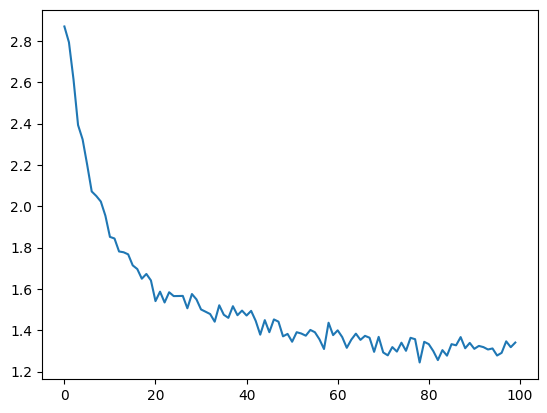

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)

C:\Users\kyse1\AppData\Local\Temp\ipykernel_26696\464984402.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\kyse1\AppData\Local\Temp\ipykernel_26696\464984402.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


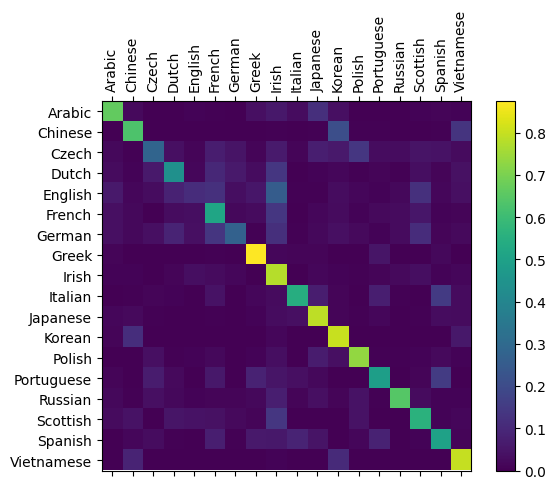

In [21]:
# Evaluating the Results

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Running on User Input

In [22]:
def predict (input_line, n_predictions=3):
    print("\n> %s" % input_line)
    
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        # Top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [27]:
predict('Conor')
predict('Harald')
predict('Schmuaer')
predict('Gekas')
predict('Yao')


> Conor
(-1.64) Irish
(-1.84) Greek
(-1.99) French

> Harald
(-1.03) Scottish
(-1.51) English
(-1.75) Arabic

> Schmuaer
(-1.08) German
(-1.27) Dutch
(-1.95) Vietnamese

> Gekas
(-0.85) Arabic
(-1.05) Greek
(-2.42) Scottish

> Yao
(-0.28) Chinese
(-1.61) Korean
(-3.39) Vietnamese
